<a href="https://colab.research.google.com/github/AkerkeKesha/stacked-unets/blob/main/gcolab_etci_flood_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set up plotting options
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gdrive_root = '/content/drive/MyDrive/stacked-unet/dataset/etci-flood-dataset'
gdrive_root

'/content/drive/MyDrive/stacked-unet/dataset/etci-flood-dataset'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/AkerkeKesha/stacked-unets.git

Cloning into 'stacked-unets'...
remote: Enumerating objects: 1438, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1438 (delta 160), reused 149 (delta 79), pack-reused 1206
Receiving objects: 100% (1438/1438), 5.35 MiB | 25.71 MiB/s, done.
Resolving deltas: 100% (988/988), done.


In [6]:
%cd stacked-unets

/content/stacked-unets


In [7]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=64008c3668a24f668374d7ee01a35014b1c6593631ef58d82c9319863f1b5bd5
  Stored in d

In [8]:
!mkdir -p /content/stacked-unets/dataset/data-etci-flood

In [9]:
!unzip -q $gdrive_root/train.zip -d /content/stacked-unets/dataset/data-etci-flood

# Couple check ups

In [10]:
%pwd

'/content/stacked-unets'

In [11]:
!git fetch

In [12]:
!git pull

Already up to date.


In [13]:
import torch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

Wed Oct 25 18:08:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [15]:
import sys

sys.path.append('/content/stacked-unets/src')

In [16]:
import os

os.environ['ENVIRONMENT'] = 'colab'
os.environ['DATASET'] = 'etci'
os.environ['STOP'] = 'yes'
os.environ['OUTPUT_TYPE'] = 'softmax_prob'

In [17]:
import os
from glob import glob
import config

print(f"Is colab: {config.dataset}")
print(f"Is colab: {config.environment}")
print(f"Output type: {config.output_type}")
print(f"Stop early?: {config.stop}")
print(f"Number of training temporal-regions: {len(glob(config.train_dir+'/*/'))}")

Is colab: etci
Is colab: colab
Output type: softmax_prob
Stop early?: yes
Number of training temporal-regions: 31


Run: [1 / 1]
Split into train:(80, 7), validation:(10, 7), and test:(10, 7)
Level: [1 / 3]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Takes 28.956371784210205 seconds to train in level1


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Input Feature Mean in Test: [-0.3785433 -0.4349125  0.       ]
Input Feature Std in Test: [0.8187273  0.84749776 0.        ]
Mean IoU for the test dataset: 0.3533296875118297
Overall average entropy for the entire test set: 0.1536
Level: [2 / 3]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.7839
Train mean loss = 0.2655
Input Feature Mean in train: [-0.10636386 -0.17336297  0.45447713]
Input Feature Std in train: [0.9636229 1.0642954 1.2347102]


  0%|          | 0/1 [00:00<?, ?it/s]

Val mean IoU = 0.6214
Val mean loss = 0.7244
Input Feature Mean in val: [0.21811485 0.02062824 0.39085656]
Input Feature Std in val: [1.2829199 1.1475204 1.2390225]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.7877
Train mean loss = 0.1945
Input Feature Mean in train: [-0.18049511 -0.21480049  0.40128464]
Input Feature Std in train: [0.9372648 1.0915078 1.1953537]


  0%|          | 0/1 [00:00<?, ?it/s]

Val mean IoU = 0.8398
Val mean loss = 0.1413
Input Feature Mean in val: [0.21811485 0.02062824 0.39085656]
Input Feature Std in val: [1.2829199 1.1475204 1.2390225]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Takes 48.33538341522217 seconds to train in level2


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Input Feature Mean in Test: [-0.3785433  -0.4349125   0.22384007]
Input Feature Std in Test: [0.8187273  0.84749776 0.7404984 ]
Mean IoU for the test dataset: 0.8241149768201761
Overall average entropy for the entire test set: 0.2293
Level: [3 / 3]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.8026
Train mean loss = 0.1825
Input Feature Mean in train: [-0.12549253 -0.19291624  1.1074438 ]
Input Feature Std in train: [0.98888755 1.0978755  2.219417  ]


  0%|          | 0/1 [00:00<?, ?it/s]

Val mean IoU = 0.6431
Val mean loss = 0.3064
Input Feature Mean in val: [0.21811485 0.02062824 0.9862401 ]
Input Feature Std in val: [1.2829199 1.1475204 2.0547695]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.7771
Train mean loss = 0.1788
Input Feature Mean in train: [-0.09020863 -0.17026532  1.098912  ]
Input Feature Std in train: [0.99087745 1.0889271  2.1946628 ]


  0%|          | 0/1 [00:00<?, ?it/s]

Val mean IoU = 0.8341
Val mean loss = 0.1224
Input Feature Mean in val: [0.21811485 0.02062824 0.9862401 ]
Input Feature Std in val: [1.2829199 1.1475204 2.0547695]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Takes 49.22865581512451 seconds to train in level3


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Input Feature Mean in Test: [-0.3785433 -0.4349125  2.0665004]
Input Feature Std in Test: [0.8187273  0.84749776 1.6664895 ]
Mean IoU for the test dataset: 0.828710314915096
Overall average entropy for the entire test set: 0.2022
Level: 1
Mean train_loss: 0.41 +/- 0.13
Mean val_loss: 13.79 +/- 7.81
Mean train_iou: 0.66 +/- 0.13
Mean val_iou: 0.44 +/- 0.01
Level: 2
Mean train_loss: 0.33 +/- 0.18
Mean val_loss: 111.85 +/- 328.08
Mean train_iou: 0.72 +/- 0.12
Mean val_iou: 0.49 +/- 0.32
Level: 3
Mean train_loss: 0.25 +/- 0.10
Mean val_loss: 0.94 +/- 1.51
Mean train_iou: 0.74 +/- 0.09
Mean val_iou: 0.63 +/- 0.20


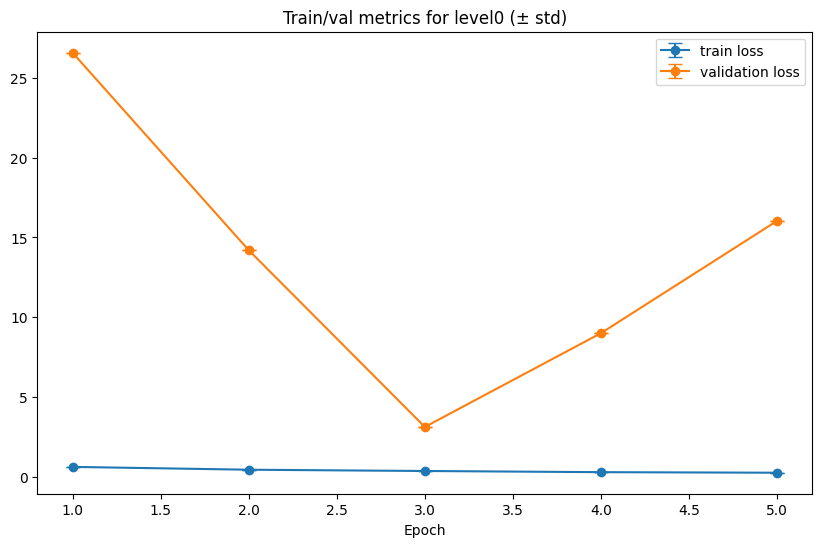

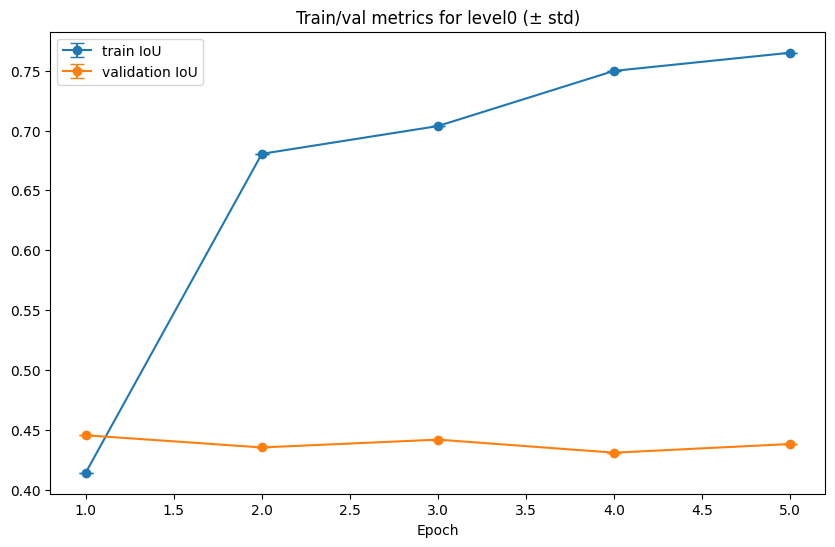

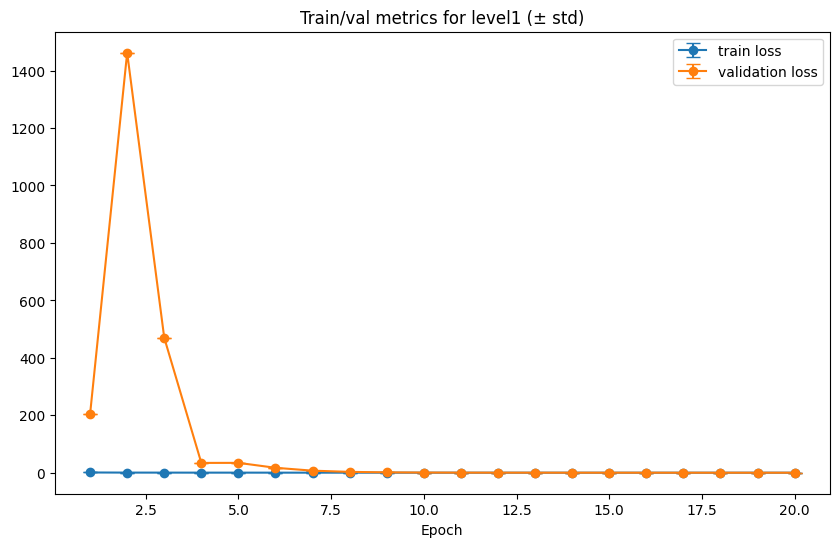

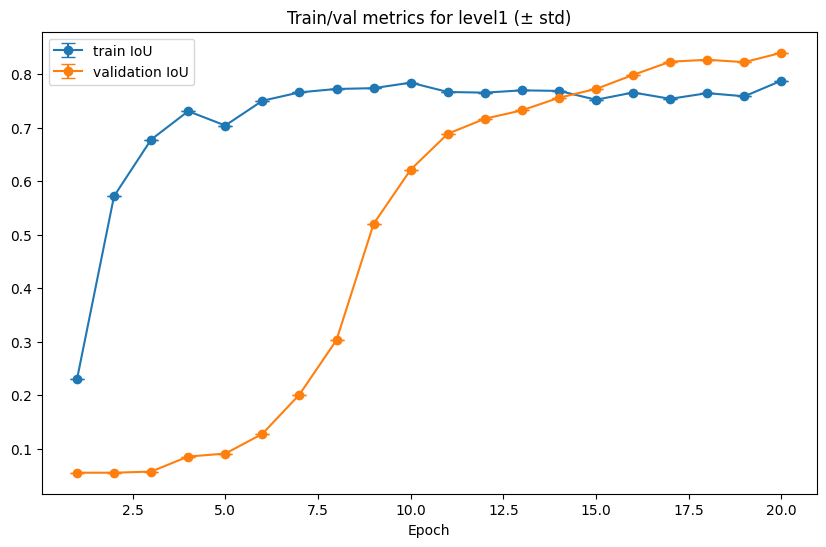

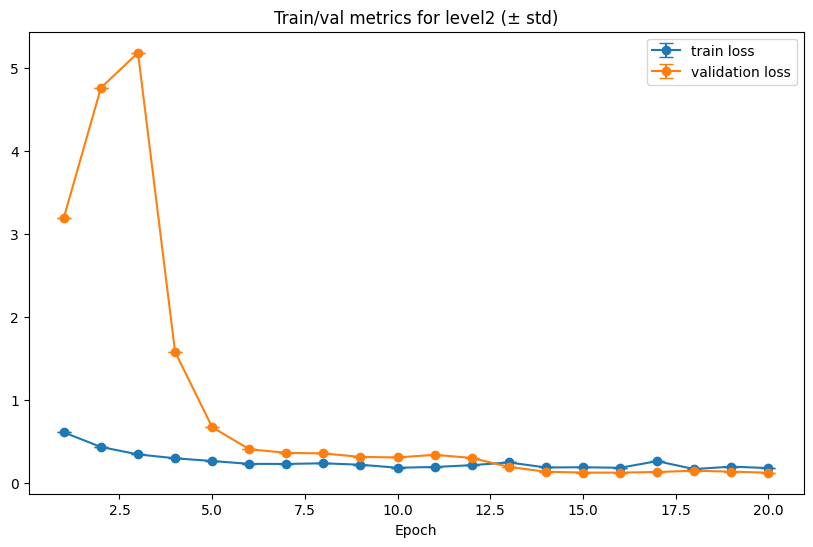

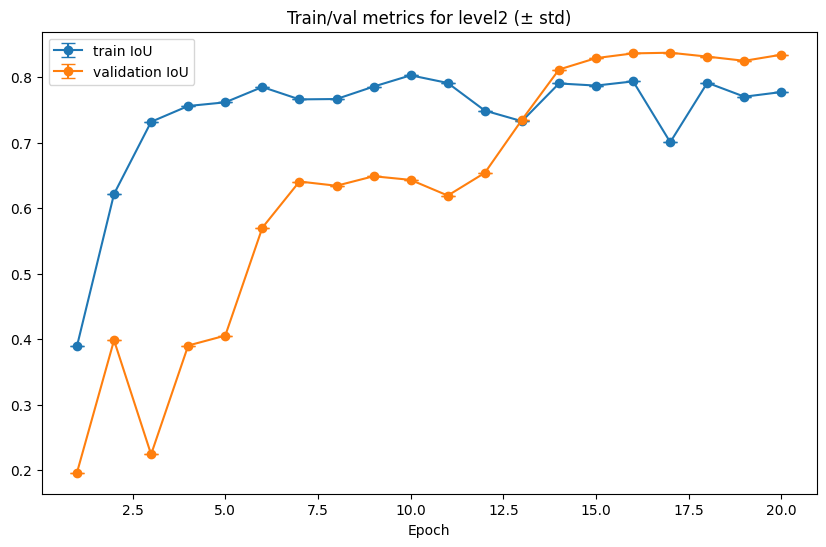

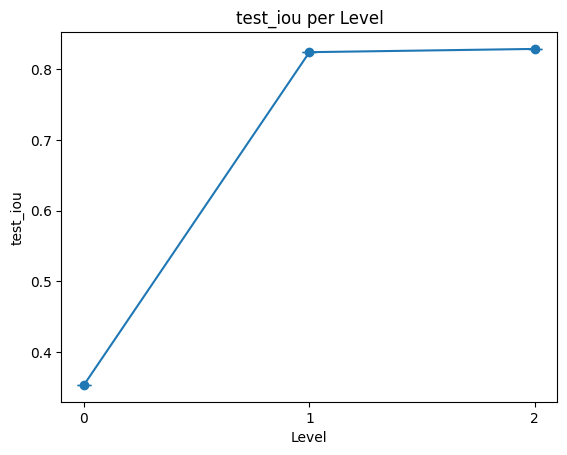

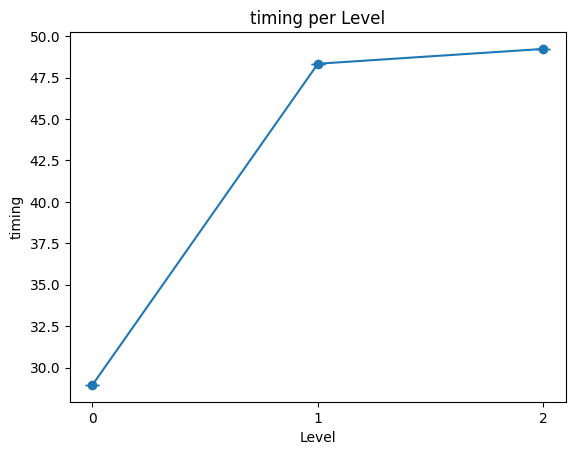

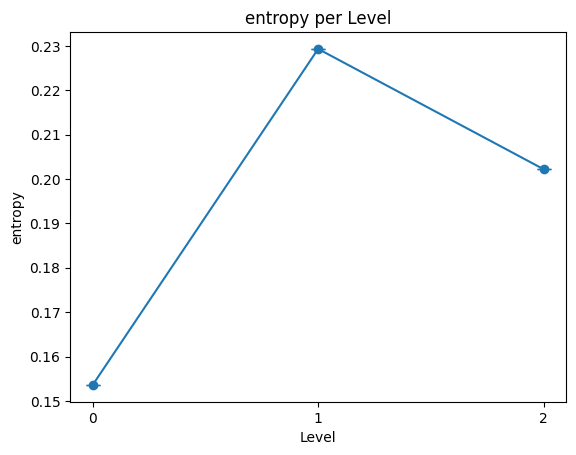

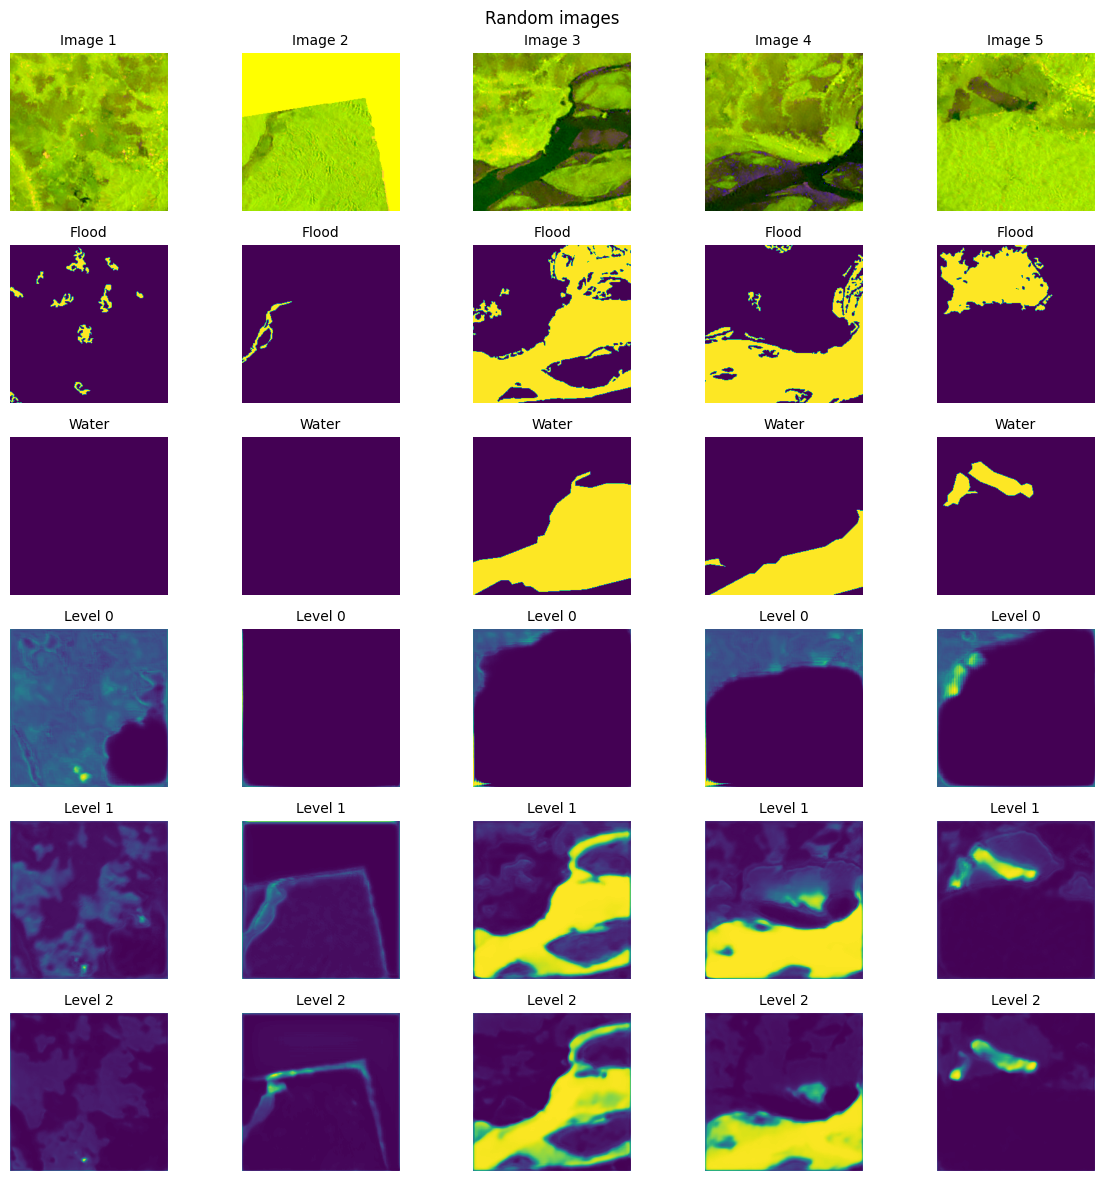

In [18]:
from src.main import run_experiments

run_experiments(runs=1, n_levels=3, max_data_points=100)

In [ ]:
# !zip -r output_5level_semantic.zip output > /dev/null 2>&1

In [ ]:
# !cp output_5level_semantic.zip "/content/drive/MyDrive/stacked-unet/output_5level_semantic.zip"

# Distortion

In [ ]:
# !cp "/content/drive/MyDrive/stacked-unet/output_5level_softmax_run0.zip" ./output.zip

In [ ]:
# !unzip ./output.zip > /dev/null 2>&1

In [19]:
import torch
import numpy as np
import pandas as pd
from src.distort import distort_maps, load_labels, predict_with_distortion

In [20]:
loaded_dict = np.load(f'{config.output_dir}/test_df_run0.npy', allow_pickle=True).item()
test_df = pd.DataFrame.from_dict(loaded_dict)
test_df = test_df.reset_index(drop=True)

In [21]:
test_df.shape

(10, 7)

In [ ]:
from src.utils import get_image_name_from_path
import cv2

n_levels = 5
def save_npy_as_png(row, labels_dir, output_dir):
    pred_image = get_image_name_from_path(row["vv_image_path"])
    for level in range(n_levels):
      prob_path = f"{labels_dir}/softmax_prob_level_{level}_image_{pred_image}.npy"
      prob = np.load(prob_path)
      scaled_probs = np.round(255 * prob).astype(np.uint8)
      prediction_path = f"{labels_dir}/pred_mask_level_{level}_image_{pred_image}.png"
      cv2.imwrite(prediction_path, scaled_probs)

In [ ]:
test_df.apply(lambda row: save_npy_as_png(row, config.labels_dir, config.output_dir), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
2498    None
2499    None
2500    None
2501    None
2502    None
Length: 2503, dtype: object

In [22]:
import albumentations as A
from torch.utils.data import DataLoader
from src.dataset import ETCIDataset


test_dataset = ETCIDataset(dataframe=test_df, split="test", transform=None)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

In [ ]:
original_maps = load_labels(config.labels_dir, target_level=3)

In [ ]:
distorted_maps = distort_maps(original_maps, proportion=1.0, num_classes=2, make_copy=True)
distorted_maps = [torch.Tensor(map_) for map_ in distorted_maps]

In [ ]:
final_predictions, new_df_test, new_mean_iou = predict_with_distortion(test_loader=test_loader,
    df_test=test_df,
    run=0,
    level=3,
    distorted_semantic_maps=distorted_maps
)

100%|██████████| 53/53 [00:41<00:00,  1.29it/s]

Mean IoU for the test dataset with distorted semantic maps: 0.7886617190135341


In [ ]:
n_levels = 5
for level in range(n_levels):
    print(f"Level {level}")
    target_level = level
    input_maps = load_labels(config.labels_dir, target_level)
    distorted_maps = distort_maps(input_maps, proportion=1.0, num_classes=2, make_copy=True)
    distorted_maps = [torch.Tensor(map_) for map_ in distorted_maps]
    final_predictions, new_df_test, new_mean_iou = predict_with_distortion(test_loader=test_loader,
        df_test=test_df,
        run=0,
        level=target_level,
        distorted_semantic_maps=distorted_maps
    )
    print(f"mean IoU for level{target_level}:{new_mean_iou}")

Level 0


100%|██████████| 53/53 [00:33<00:00,  1.57it/s]


Mean IoU for the test dataset with distorted semantic maps: 0.7171736812293461
mean IoU for level0:0.7171736812293461
Level 1


100%|██████████| 53/53 [00:33<00:00,  1.58it/s]


Mean IoU for the test dataset with distorted semantic maps: 0.7574115930306224
mean IoU for level1:0.7574115930306224
Level 2


100%|██████████| 53/53 [00:34<00:00,  1.54it/s]


Mean IoU for the test dataset with distorted semantic maps: 0.78813225206095
mean IoU for level2:0.78813225206095
Level 3


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]


Mean IoU for the test dataset with distorted semantic maps: 0.7887284111197455
mean IoU for level3:0.7887284111197455
Level 4


100%|██████████| 53/53 [00:32<00:00,  1.62it/s]

Mean IoU for the test dataset with distorted semantic maps: 0.7816863055791229
mean IoU for level4:0.7816863055791229
